In [1]:
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt


# read GeoTIFF file
ds = gdal.Open('NZ24ne_DTM_1m.tif') #north east of NZ24
band = ds.GetRasterBand(1)
elevation_data = band.ReadAsArray()


(5000, 5000)


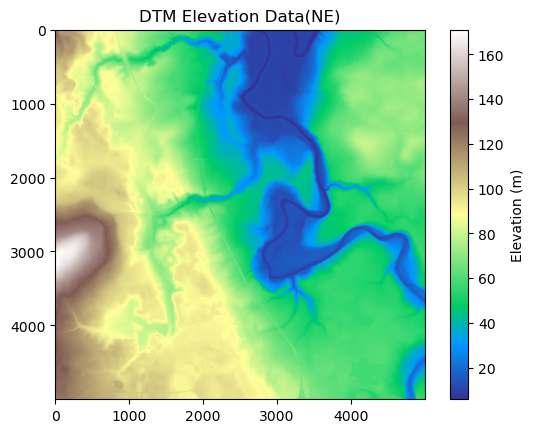

In [2]:
if ds is None:
    print("Failed to open file")
else:
    band = ds.GetRasterBand(1)
    elevation_data = band.ReadAsArray()

    # print DTM shape
    print(elevation_data.shape)

    # visualization
    plt.imshow(elevation_data, cmap='terrain')
    plt.colorbar(label='Elevation (m)')
    plt.title('DTM Elevation Data(NE)')
    plt.show()

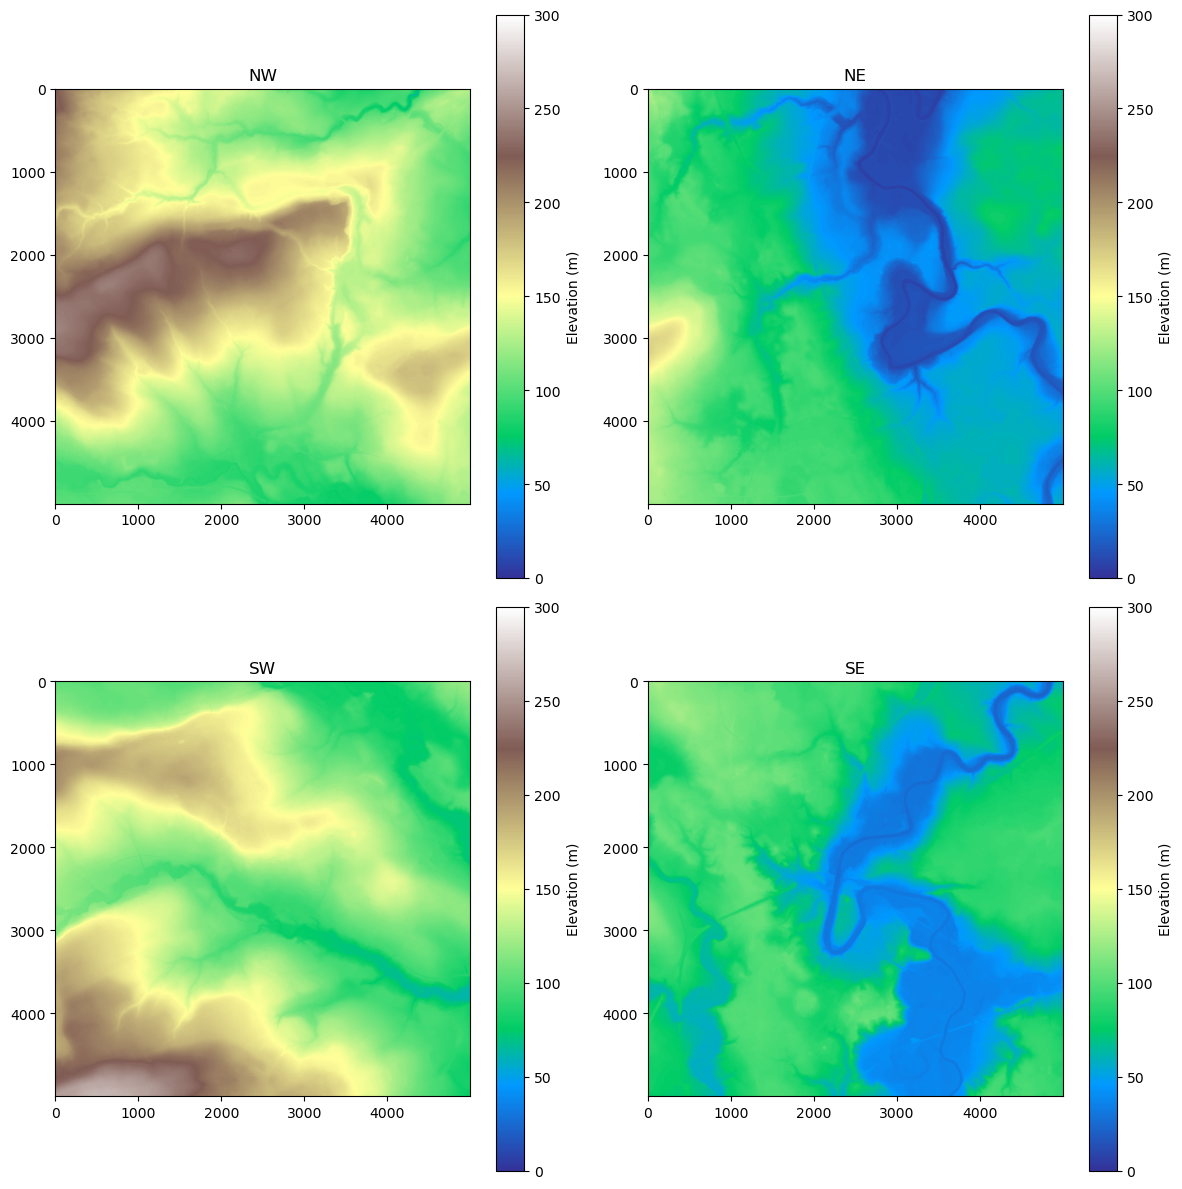

In [3]:
# 4 parts
file_NE = 'NZ24ne_DTM_1m.tif'
file_NW = 'NZ24nw_DTM_1m.tif'
file_SE = 'NZ24se_DTM_1m.tif'
file_SW = 'NZ24sw_DTM_1m.tif'

# open GeoTIFF files
ds_NE = gdal.Open(file_NE)
ds_NW = gdal.Open(file_NW)
ds_SE = gdal.Open(file_SE)
ds_SW = gdal.Open(file_SW)

# get band
band_NE = ds_NE.GetRasterBand(1)
band_NW = ds_NW.GetRasterBand(1)
band_SE = ds_SE.GetRasterBand(1)
band_SW = ds_SW.GetRasterBand(1)

# read array
array_NE = band_NE.ReadAsArray()
array_NW = band_NW.ReadAsArray()
array_SE = band_SE.ReadAsArray()
array_SW = band_SW.ReadAsArray()


# visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))


cmap = 'terrain'

axes[0, 0].imshow(array_NW, cmap=cmap, vmin=0, vmax=300)
axes[0, 0].set_title('NW')

axes[0, 1].imshow(array_NE, cmap=cmap, vmin=0, vmax=300)
axes[0, 1].set_title('NE')

axes[1, 0].imshow(array_SW, cmap=cmap, vmin=0, vmax=300)
axes[1, 0].set_title('SW')

axes[1, 1].imshow(array_SE, cmap=cmap, vmin=0, vmax=300)
axes[1, 1].set_title('SE')

for ax in axes.flat:
    cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
    cbar.set_label('Elevation (m)')

plt.tight_layout()

plt.show()

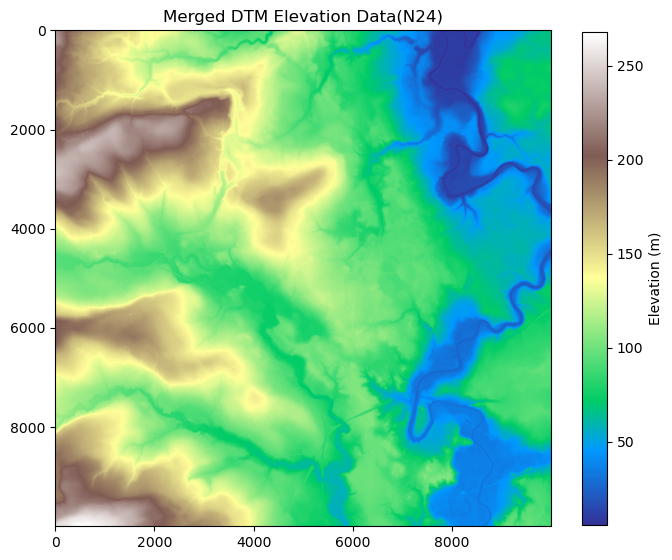

In [4]:
top = np.hstack((array_NW, array_NE))
bottom = np.hstack((array_SW, array_SE))
merged_array = np.vstack((top, bottom))

# visualization
plt.figure(figsize=(8,8))
cmap = 'terrain'

plt.imshow(merged_array, cmap=cmap)
plt.colorbar(shrink=0.8, label='Elevation (m)')
plt.title('Merged DTM Elevation Data(N24)')

plt.show()

In [5]:
np.save('merged_array.npy', merged_array)

In [2]:
merged_array = np.load('merged_array.npy')

In [8]:
merged_array.shape

(10000, 10000)

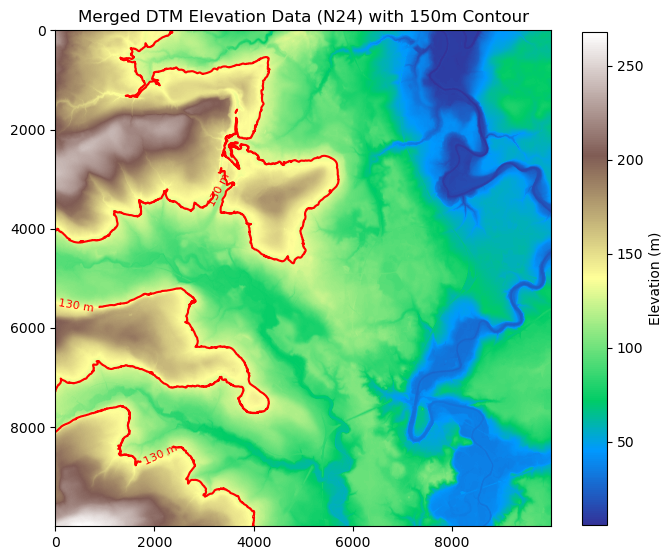

In [10]:
plt.figure(figsize=(8, 8))
cmap = 'terrain'

#colorbar
plt.imshow(merged_array, cmap=cmap)
plt.colorbar(shrink=0.8, label='Elevation (m)')

#150m equipotential lines
contour_levels = [130]  
contours = plt.contour(merged_array, levels=contour_levels, colors='red')


plt.clabel(contours, inline=True, fontsize=8, fmt='%d m')


plt.title('Merged DTM Elevation Data (N24) with 150m Contour')


plt.show()


In [11]:
np.min(merged_array)

5.822458

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split


In [25]:
import numpy as np

#we set elevation > 150 as mountain and 25 as river
mountain_threshold = 135
river_threshold = 35


label_array = np.zeros_like(merged_array, dtype=np.uint8)

# mountain label
label_array[merged_array >= mountain_threshold] = 1

# river label
label_array[merged_array <= river_threshold] = 2

def label_block(block, mountain_threshold, river_threshold):
    if np.any(block > mountain_threshold):
        return 1
    elif np.any(block < river_threshold):
        return 2
    else:
        return 0

In [6]:
#split into blocks
np.random.seed(42) 

block_size = 250

def split_into_blocks(array, block_size):
    n_blocks = array.shape[0] // block_size
    blocks = []
    for i in range(n_blocks):
        for j in range(n_blocks):
            block = array[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            blocks.append(block)
    return np.array(blocks)

input_blocks = split_into_blocks(merged_array, block_size)
#label_blocks = split_into_blocks(label_array, block_size)
#label_blocks = np.array([np.any(block > threshold) for block in input_blocks]).astype(np.uint8)
#label_blocks = np.array([label_block(block, mountain_threshold, river_threshold) for block in input_blocks])
label_blocks = kmean_clusters_M - 1

In [25]:
#average height
def block_average(arr, block_size):
    shape = (arr.shape[0] // block_size, arr.shape[1] // block_size)
    sh = shape[0], block_size, shape[1], block_size
    return arr.reshape(sh).mean(-1).mean(1)

block_size = 250
block_average_array = block_average(merged_array, block_size)

# 将平均值的数组重塑为40x40
block_average_2d = block_average_array.reshape((40, 40))

In [4]:
#k-means mountain
import pandas as pd
kmean_clusters = pd.read_csv('km_res_clusters.csv')
kmean_clusters_np = kmean_clusters.to_numpy()

# 创建一个新的数组来存储只保留1值的结果
#kmean_clusters_M = np.copy(kmean_clusters_np)
kmean_clusters_M = kmean_clusters_np
# 将所有非 1 的值变为 0
#kmean_clusters_M[kmean_clusters_M != 1] = 0

# 打印数组的形状
print(kmean_clusters_M.shape)

(1600, 1)


In [49]:
labels = np.load('labels.npy')
labels.shape

(40, 40)

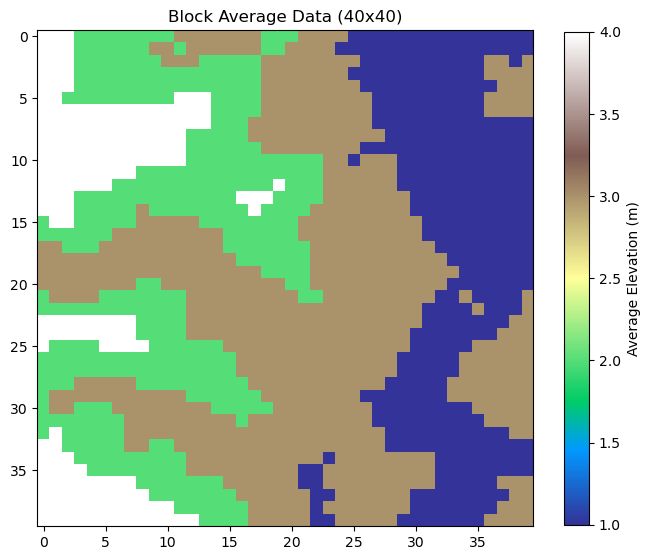

In [5]:
kmean_M_2d = kmean_clusters_M.reshape((40, 40))
"""
result = np.zeros_like(kmean_M_2d)

# 遍历两个数组，根据条件更新 result 数组
for i in range(kmean_M_2d.shape[0]):
    for j in range(kmean_M_2d.shape[1]):
        if kmean_M_2d[i, j] == 1:
            result[i, j] = 1
        elif labels[i, j] == 2:
            result[i, j] = 2

# 将结果保存回 labels 数组
labels = result

"""

# 可视化 label_blocks_2d
plt.figure(figsize=(8, 8))
cmap = 'terrain'

plt.imshow(kmean_M_2d, cmap=cmap)
plt.colorbar(shrink=0.8, label='Average Elevation (m)')
plt.title('Block Average Data (40x40)')

plt.show()

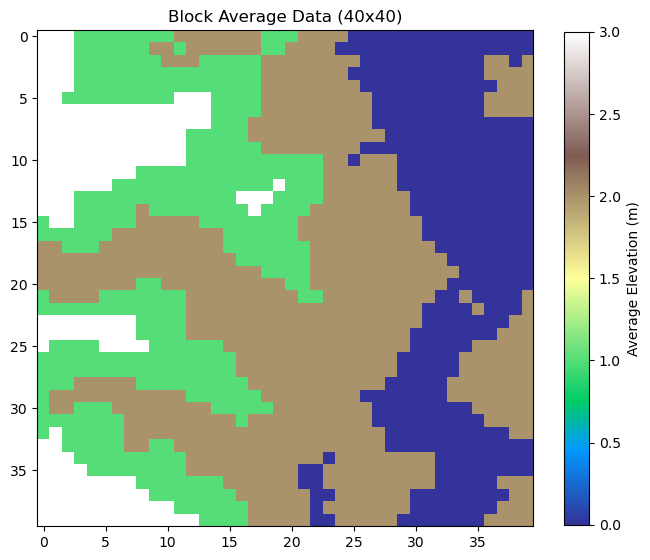

In [7]:
#easy label
label_blocks_2d = label_blocks.reshape((40, 40))

# 可视化 label_blocks_2d
plt.figure(figsize=(8, 8))
cmap = 'terrain'

plt.imshow(label_blocks_2d, cmap=cmap)
plt.colorbar(shrink=0.8, label='Average Elevation (m)')
plt.title('Block Average Data (40x40)')

plt.show()

In [55]:
print(label_blocks.shape)
print(input_blocks.shape)

(1600, 1)
(1600, 250, 250)


In [8]:
from sklearn.model_selection import train_test_split
input_blocks_train, input_blocks_test, label_blocks_train, label_blocks_test = train_test_split(
    input_blocks, label_blocks, test_size=0.2, random_state=42, stratify=label_blocks
)

print(f"input_blocks_train: {input_blocks_train.shape}")
print(f"label_blocks_train: {label_blocks_train.shape}")
print(f"input_blocks_test: {input_blocks_test.shape}")
print(f"label_blocks_test: {label_blocks_test.shape}")

input_blocks_train: (1280, 250, 250)
label_blocks_train: (1280, 1)
input_blocks_test: (320, 250, 250)
label_blocks_test: (320, 1)


In [110]:
from sklearn.utils import resample
import numpy as np

# 创建一个 DataFrame 方便操作
import pandas as pd
df = pd.DataFrame({'input': list(input_blocks), 'label': list(label_blocks)})

# 分离各类别数据
df_majority = df[df.label == 0]
df_minority_1 = df[df.label == 1]
df_minority_2 = df[df.label == 2]

# 对少数类别进行过采样
df_minority_1_oversampled = resample(df_minority_1,
                                     replace=True,
                                     n_samples=len(df_majority),
                                     random_state=42)
df_minority_2_oversampled = resample(df_minority_2,
                                     replace=True,
                                     n_samples=len(df_majority),
                                     random_state=42)

# 合并数据
df_balanced = pd.concat([df_majority, df_minority_1_oversampled, df_minority_2_oversampled])

# 打乱数据
df_balanced = df_balanced.sample(frac=1, random_state=42)

# 重新拆分数据
input_blocks_balanced = np.array(df_balanced['input'].tolist())
label_blocks_balanced = np.array(df_balanced['label'].tolist())

input_blocks_train, input_blocks_test, label_blocks_train, label_blocks_test = train_test_split(
    input_blocks_balanced, label_blocks_balanced, test_size=0.2, random_state=42, stratify=label_blocks_balanced
)

print(f"input_blocks_train: {input_blocks_train.shape}")
print(f"label_blocks_train: {label_blocks_train.shape}")
print(f"input_blocks_test: {input_blocks_test.shape}")
print(f"label_blocks_test: {label_blocks_test.shape}")

input_blocks_train: (2529, 250, 250)
label_blocks_train: (2529, 1)
input_blocks_test: (633, 250, 250)
label_blocks_test: (633, 1)


In [30]:
np.max(label_blocks_train)

3

In [18]:
input_blocks_train[0]

array([[67.729   , 67.616005, 67.503006, ..., 69.716   , 69.741005,
        69.73    ],
       [67.809006, 67.692   , 67.657005, ..., 69.706   , 69.699005,
        69.69601 ],
       [67.911   , 68.      , 67.996   , ..., 69.694   , 69.68301 ,
        69.700005],
       ...,
       [49.911   , 49.924   , 49.92    , ..., 61.144   , 61.509   ,
        61.683   ],
       [49.868   , 49.873   , 49.86    , ..., 60.935   , 61.169   ,
        61.549   ],
       [49.806   , 49.8     , 49.78    , ..., 60.718   , 60.957   ,
        61.3     ]], dtype=float32)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D



model = tf.keras.models.Sequential([
    
    
    
    tf.keras.layers.Conv2D(32,(3,3), activation='relu', input_shape=(250, 250, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    tf.keras.layers.Conv2D(64,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    
    tf.keras.layers.Conv2D(128,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(256,(3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4),
    
    
    #tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'),
    #tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu'),

    # output
    #tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
])


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 248, 248, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 124, 124, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 122, 122, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 59, 59, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 29, 29, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 27, 27, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 11, 11, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,321,412 (16.48 MB)

 Trainable params: 4,321,412 (16.48 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.optimizers import Adam
#optimizer = Adam(learning_rate=0.001)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(input_blocks_train, label_blocks_train, epochs=10, 
                    validation_data=(input_blocks_test, label_blocks_test))


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3169 - loss: 8.7425 - val_accuracy: 0.4187 - val_loss: 1.2990
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.3768 - loss: 1.3002 - val_accuracy: 0.4313 - val_loss: 1.2770
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4430 - loss: 1.2495 - val_accuracy: 0.5000 - val_loss: 1.1770
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5796 - loss: 1.1698 - val_accuracy: 0.6094 - val_loss: 1.1992
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.4850 - loss: 2.4981 - val_accuracy: 0.4375 - val_loss: 1.1241
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.5352 - loss: 1.0978 - val_accuracy: 0.5781 - val_loss: 1.0352
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5244 - loss: 1.0602 - val_accuracy: 0.5906 - val_loss: 0.9929
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6149 - loss: 0.9601 - val_accuracy: 0.6750 - val_loss:

10/10 - 3s - 324ms/step - accuracy: 0.8188 - loss: 0.6549


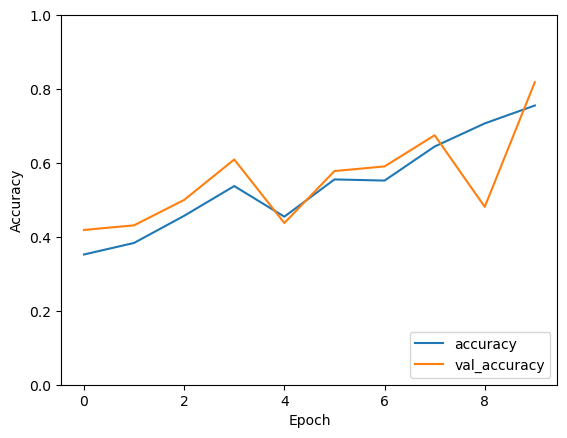

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(input_blocks_test,  label_blocks_test, verbose=2)

In [41]:
print(test_acc)

0.699999988079071


In [44]:
predictions = model.predict(input_blocks_test)
#predicted_labels = (predictions > 0.5).astype(np.uint8)

predicted_labels = np.argmax(predictions, axis=1)

for i in range(len(input_blocks_test)):
    print(f"Sample {i}: Predicted label: {predicted_labels[i]}, True label: {label_blocks_test[i]}, Probabilities: {predictions[i]}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step
Sample 0: Predicted label: 1, True label: [3], Probabilities: [-2.450051    2.9870782   0.35352322  2.2074742 ]
Sample 1: Predicted label: 2, True label: [2], Probabilities: [ 5.2949486  2.3607585  5.66038   -3.5155437]
Sample 2: Predicted label: 2, True label: [2], Probabilities: [ 5.5998263  2.4544036  5.821302  -3.743666 ]
Sample 3: Predicted label: 0, True label: [0], Probabilities: [ 8.877141  3.797412  6.852617 -6.720714]
Sample 4: Predicted label: 1, True label: [3], Probabilities: [-2.3749766   2.9000227   0.38496456  2.122477  ]
Sample 5: Predicted label: 0, True label: [0], Probabilities: [11.6488495  4.9489455  7.202058  -9.273937 ]
Sample 6: Predicted label: 0, True label: [0], Probabilities: [ 9.249989   3.948325   6.8335977 -7.1134377]
Sample 7: Predicted label: 2, True label: [1], Probabilities: [-0.7569806   1.1733384   1.5855497   0.44196695]
Sample 8: Predicted label: 0, True label: [0], Probabilities: [ 9.221204   3.9325464  6

In [22]:
predictions = model.predict(input_blocks)

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 313ms/step


In [23]:
predicted_labels = np.argmax(predictions, axis=1)

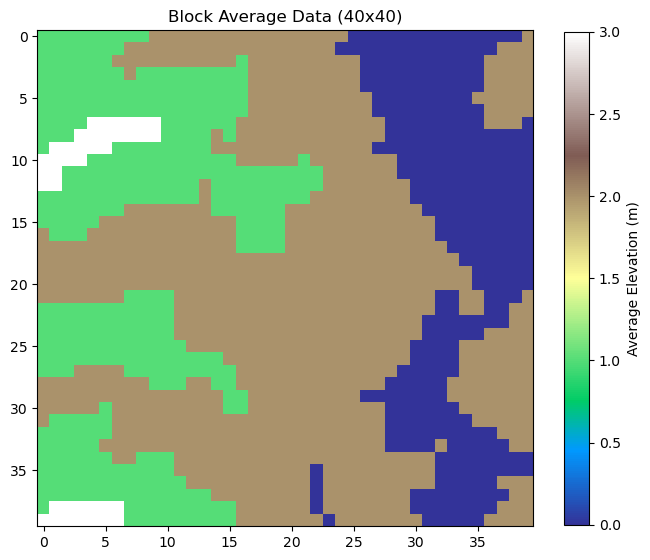

In [24]:
predicted_labels_2d = predicted_labels.reshape(40,40)

plt.figure(figsize=(8, 8))
cmap = 'terrain'

plt.imshow(predicted_labels_2d, cmap=cmap)
plt.colorbar(shrink=0.8, label='Average Elevation (m)')
plt.title('Block Average Data (40x40)')

plt.show()

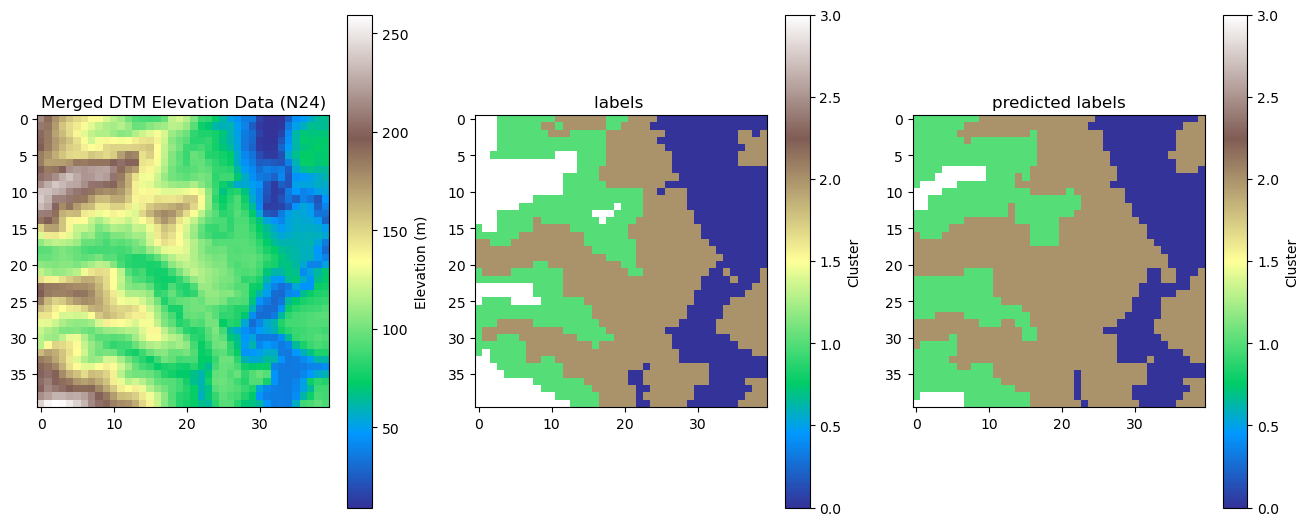

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16, 8))

cmap = 'terrain'

# merged_array plot
im1 = axes[0].imshow(block_average_2d, cmap=cmap)
axes[0].set_title('Merged DTM Elevation Data (N24)')
fig.colorbar(im1, ax=axes[0], shrink=0.8, label='Elevation (m)')

# label
im2 = axes[1].imshow(label_blocks_2d, cmap=cmap)
axes[1].set_title('labels ')
fig.colorbar(im2, ax=axes[1], shrink=0.8, label='Cluster')

# predicted label
im3 = axes[2].imshow(predicted_labels_2d, cmap=cmap)
axes[2].set_title('predicted labels')
fig.colorbar(im2, ax=axes[2], shrink=0.8, label='Cluster')

# show
plt.show()

In [ ]:
np.min(input_blocks_train[39])

In [111]:
unique, counts = np.unique(label_blocks_train, return_counts=True)
label_distribution = dict(zip(unique, counts))
print("Label distribution in label_blocks_train:", label_distribution)


Label distribution in label_blocks_train: {0: 843, 1: 843, 2: 843}


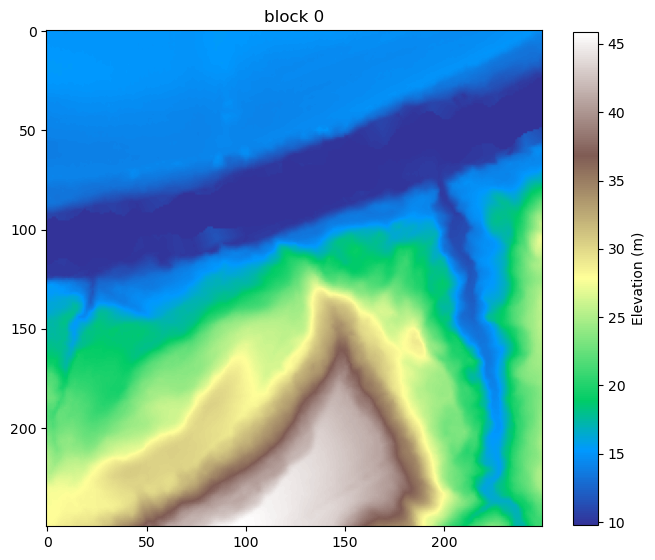

In [63]:
plt.figure(figsize=(8,8))
cmap = 'terrain'

plt.imshow(input_blocks_train[39], cmap=cmap)
plt.colorbar(shrink=0.8, label='Elevation (m)')
plt.title('block 0')

plt.show()